Attempt at training a ML algorithm to replace OIR MKID real time data processing.

Aiming to replace IQ low pass filters, conversion to phase, optimal filtering, and 
triggering with a single ML algorithm.












**Import Statements**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**Data Generation**

In [ ]:
datadir  = '/content/drive/MyDrive/Coursework/Google Colab/OIR MKID Replacement/' #this line is the filepath in my personal google drive

def plotPulse(I,Q,I_trace,Q_trace):
  plt.plot(I,Q)
  plt.title('I Q data')
  plt.show()
  plt.title('I Q trace data')
  plt.scatter(I_trace,Q_trace,s=0.25,c='red')

if __name__ == '__main__':
  # Load sweep data
  sweep = np.load(datadir+'sweep.npz')
  f = sweep['f']
  z = sweep['z']
  I = z.real
  Q = z.imag


  # Load all wavelengths
  fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz']
  i_trace = []
  q_trace = []
  peak_heights = []
  peak_indices = []
  filtered_data = []
  for i in range(5):
        data = np.load(datadir+fnames[i])
        i_trace.append(data['i_trace'])
        q_trace.append(data['q_trace'])
        filtered_data.append(data['filtered_data'])
        peak_heights.append(data['peak_heights'])
        peak_indices.append(data['peak_indices'])
        data_size = data['i_trace'][:,0].size

  # Create Fake Data Stream
  SampRate = 2000000      # Sample rate is 2 MHz
  TrainingTime = 0.01      # Training data set length in sec
  PhotonRate = 1000.0      # Photon Arrival rate in photons/sec
  N = int(SampRate*TrainingTime)

  i_train=np.zeros(N)
  q_train=np.zeros(N)
  label=np.zeros(N)
  peaks=np.zeros(N,dtype=int)
  time = np.linspace(0,TrainingTime,N)

  # start by copying noise from first 400 data points of each pulse into the training set
  pos = 0
  while pos <= N-400:
        i_train[pos:pos+400] = i_trace[0][int((pos/400)%data_size),0:400]
        q_train[pos:pos+400] = q_trace[0][int((pos/400)%data_size),0:400]
        label[pos:pos+400] = filtered_data[0][int((pos/400)%data_size),0:400]
        pos += 400

  # Now copy in the correct number of pulses (based on PhotonRate) at random times
  Nphot = int(PhotonRate*TrainingTime + np.random.randn()*np.sqrt(PhotonRate*TrainingTime))

  for i in range(Nphot):
        at = np.random.randint(N-500) # time index to insert pulse
        pulse = np.random.randint(data_size)
        laser = np.random.randint(5)
        pmax = peak_indices[laser][pulse]
        if(pmax<400 or pmax>600):  # skip pulses where peak is outside of the center of the data frame
            continue
        label[at-100:at+400] = filtered_data[laser][pulse,pmax-100:pmax+400]
        i_train[at-100:at+400] = i_trace[laser][pulse,pmax-100:pmax+400]
        q_train[at-100:at+400] = q_trace[laser][pulse,pmax-100:pmax+400]
        peaks[at] = 1
  
  

  #Save the training data
  np.savez('training.npz',I=i_train,Q=q_train,label=label,peaks=peaks,time = time)


**Visualize Data**

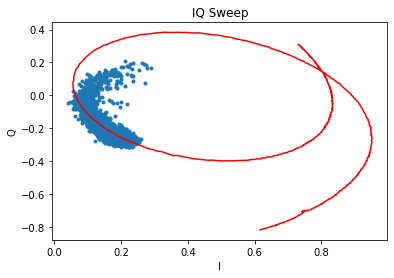

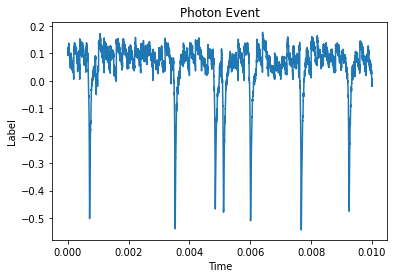

In [ ]:
#this cell can be skipped in runtime if desired.
data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
peaks = data['peaks']
time = data['time']

plt.title('IQ Sweep')
plt.plot(-I,Q,linestyle = '',marker='.') #negative I and negative z.real is used to correct phasor diagram to have correct orientation(aesthetics)
plt.plot(-z.real,z.imag, c='red')
plt.xlabel("I")
plt.ylabel('Q')
plt.show()

plt.title("Photon Event")
plt.plot(time,label)
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()



#free up memory
data = 0
I = 0
Q = 0
label = 0
peaks = 0
time = 0


**Model Training**

In [ ]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, c="b", label="Training loss")
    plt.plot(epochs, val_loss,c="r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

if __name__ == '__main__':
  data = np.load('training.npz')
  I = data['I']
  Q = data['Q']
  label = data['label']
  peaks = data['peaks']
  time = data['time']
  data = 0 #free up memory

  #normalize data
  I = normalize(I)
  Q = normalize(Q)
  label = normalize(label)

  #create an array with the time data as it's 0 axis for tf.keras.utils.timeseries_dataset_from_array
  input_data = np.zeros(shape=(I.size,3))
  input_data[:,0] = time #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
  input_data[:,1] = I
  input_data[:,2] = Q
  
  #create targets array
  input_targets = np.zeros(shape=(I.size,2))
  input_targets[:,0] = time
  input_targets[:,1] = label
  
  
  
  #free up memory
  time = 0
  I = 0
  Q = 0 

  #set up training dataset
  split_fraction = 0.8
  sequence_length = 40
  batch_size = 20
  vector_size = input_data[0,:].size
  vector_length = input_data[:,0].size
  sampling_rate = 1/SampRate
  split_index = int(split_fraction*vector_length)
  
  
  dataset_train = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = label,
      sequence_length = sequence_length,
      sampling_rate = sampling_rate,
      batch_size = batch_size,
      end_index = int(split_fraction*vector_size)
  )
  dataset_val = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = label,
      sequence_length = sequence_length,
      sampling_rate = sampling_rate,
      batch_size = batch_size,
      start_index = int(split_fraction*vector_size),
  )

  #save memory now that these are no longer needed
  input_data = 0
  label = 0

  
  #prepare model
  input_shape = (batch_size, sequence_length, vector_size)
  model = tf.keras.Sequential([
       tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'causal',activation = 'relu', input_shape = input_shape[1:]),
       tf.keras.layers.LSTM(32,return_sequences=True),
       tf.keras.layers.LSTM(32,return_sequences=True),
       tf.keras.layers.Dense(1)
  ])

  #hyperparameters
  learning_rate = 1e-4
  epochs = 500
  
  
  #compile model
  model.compile(
      loss = 'Huber',
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      metrics = ['mae']
  )
  
  #model_checkpoint and early stopping callbakcs
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20)) #figure out optimal learning rate
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
  
  #fit model
  history = model.fit(dataset_train, epochs=epochs,validation_data=dataset_val, callbacks=[lr_schedule, early_stopping, model_checkpoint]) 
  np.save("my_history.npy", history.history)


3
Epoch 1/500
7/7 [==============================] - 14s 214ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.0000e-07
Epoch 2/500
7/7 [==============================] - 0s 59ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.1220e-07
Epoch 3/500
7/7 [==============================] - 0s 59ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.2589e-07
Epoch 4/500
7/7 [==============================] - 0s 62ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.4125e-07
Epoch 5/500
7/7 [==============================] - 0s 59ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.5849e-07
Epoch 6/500
7/7 [==============================] - 0s 59ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - val_mae: 0.2538 - lr: 1.7783e-07
Epoch 7/500
7/7 [==============================] - 0s 62ms/step - loss: 0.1452 - mae: 0.3031 - val_loss: 0.1046 - 

**Training Metrics**

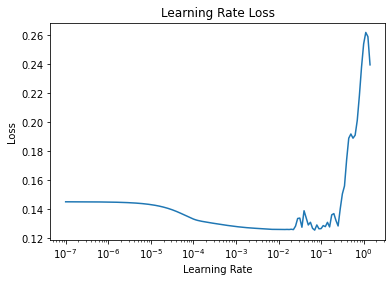

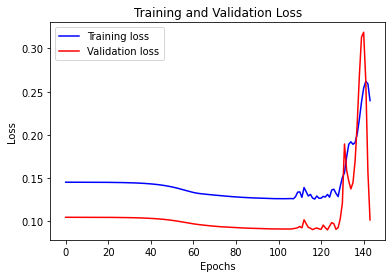

In [ ]:
#display Loss as a function of Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel("Learning Rate")
plt.title("Learning Rate Loss")
plt.ylabel("Loss")
plt.show()

#Display Loss as a function of epochs
visualize_loss(history,"Training and Validation Loss")